# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Answer
This is a supervised learning regression problem.  Our features will include data like make, model, mileage, year, etc and our target variable will be the price that the car was sold for.  After constructing a sufficiently accurate model, we will assess the feature coefficients to determine which features have the highest impact the the sale price.


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. Load data into a pandas Dataframe

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

raw_data = pd.read_csv("data/vehicles.csv")

2. use .head(), .info(), .shape(), and .describe() to get a high-level understanding of the data.

In [2]:
raw_data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [3]:
raw_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  str    
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  str    
 5   model         421603 non-null  str    
 6   condition     252776 non-null  str    
 7   cylinders     249202 non-null  str    
 8   fuel          423867 non-null  str    
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  str    
 11  transmission  424324 non-null  str    
 12  VIN           265838 non-null  str    
 13  drive         296313 non-null  str    
 14  size          120519 non-null  str    
 15  type          334022 non-null  str    
 16  paint_color   296677 non-null  str    
 17  state         426880 non-null  str    
dtypes: float64(2), 

In [4]:
raw_data.shape

(426880, 18)

In [5]:
raw_data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


3. use .isnull() and .nunique() to further assess the quality of the data set and determine which fields are actually categories

In [6]:
print(raw_data.isnull().sum())

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


In [7]:
raw_data.nunique()

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

4. explore unique values for each column and distributions for attributes like `price` and `year`

### Price
Rows with 0 `price` aren't useful, and therefore should be dropped.  The same goes for any row with a `price` less than $2000.  Those rose are either bad data, or special cases that our model won't be able to capture.  There are also rows with abnormally high `price` outliers that probably represent antiques or exotic cars and low `price` outliers that probably represent salvage or junk vehicles.  These should also be removed.  We will rely on IQR calculations to determine the exact cutoff points for outliers.

Even after dropping outliers, the `price` column spans several orders of magnitude.  We will, therefore, replace it with the log of the original value.


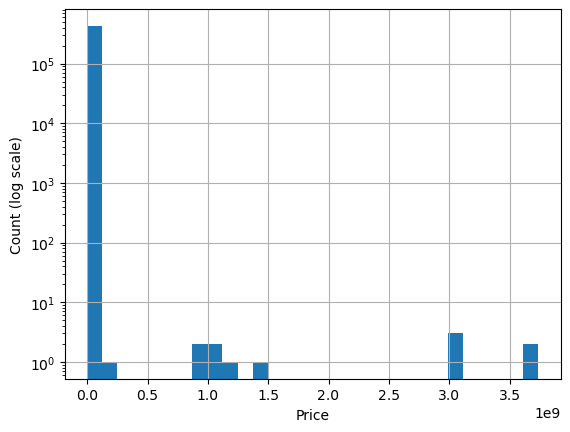

In [8]:
# Plot a histogram of the price of cars in the data set.  Use a logrithmic scale.
raw_data['price'].hist(bins=30, log=True)
plt.xlabel('Price')
plt.ylabel('Count (log scale)')
plt.show()

In [9]:
# Number of cars with price greater than $100,000 (as a rough upper outlier cutoff)
len(raw_data[raw_data['price'] > 100_000])

655

In [10]:
# Numer of cars with price less than $2000
len(raw_data[raw_data['price'] < 2000])

52977

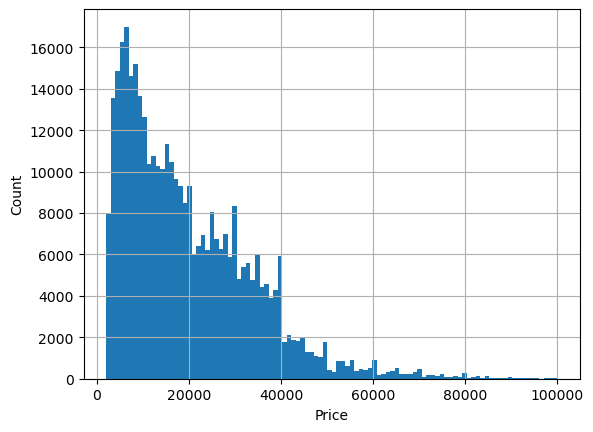

In [11]:
# Histogram of prices greater than $2000 and less than $100,000
raw_data[(raw_data['price'] < 100_000) & (raw_data['price'] > 2000)]['price'].hist(bins=100)
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

### Region
The `region` column has many distinct values without a standard formatting.  It should not be included as a feature. 

In [12]:
raw_data['region'].value_counts()

region
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: count, Length: 404, dtype: int64

### Year
The `year` column contains statistical outliers, which should be dropped.  There are also rows with empty values which should be dropped.

We will also replace `year` with `age`, which will be easier to interpret when analyzing the model results.

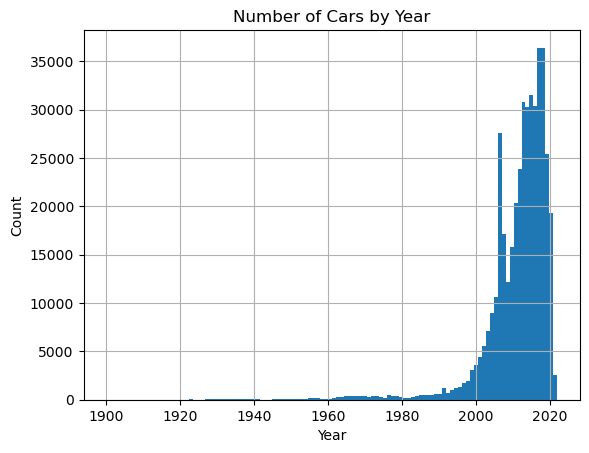

In [13]:
raw_data['year'].hist(bins=raw_data['year'].nunique())
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of Cars by Year')
plt.show()

### Manufacturer
The `manufacturer` column is well formatted and is suitable for one-hot encoding.  This is good because car manufacturer does have an effect on the price of a car.  For example, BMWs normally sell for more than Fords.  

The data set does include rows with `harley-davidson` as the manufacturer.  Harley-Davidson makes motorcycles, which would probably follow a different pricing model than cars, so they should be dropped.  Any rows with null values should also be dropped.

We will also combine rows with extremely small counts into an "other" group to prevent the model from overindexing on low sample size.

Given the high cardinality of the `manufacturer` column, using it as a feature may result in a model that is not interpretable in a general way.  We will model it both ways and assess.

In [14]:
raw_data['manufacturer'].value_counts(dropna=False)

manufacturer
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
NaN                17646
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
datsun      

### Model
`model` has too many unique values across many manufacturers to be usable as a feature, even if it was better formatted.

In [15]:
raw_data['model'].value_counts()

model
f-150                      8009
silverado 1500             5140
1500                       4211
camry                      3135
silverado                  3023
                           ... 
rx& gls sport                 1
ATI                           1
gand wagoneer                 1
96 Suburban                   1
Paige Glenbrook Touring       1
Name: count, Length: 29649, dtype: int64

### Condition
`condition` should have a high impact on price and the data is well-formatted, so we should use it.  The data set contains rows with `new` and `salvage` as their `condition`. These rows should be dropped as they don't pertain to our objective.  Any rows without a value should also be dropped. 

`condition` is an ordered attribute, and in theory `like new` is better than `excellent`, which is better than `good`, which is better than `fair`. Interestingly, the data show that rows with `good` `condition` seem to sell better than `like new`, and `excellent`.  This may be because sellers tend to inflate the condition in order to make a sale.  We will replace the column with ordinal integers instead of using one-hot encoding, but we will rank `good` as the highest.



In [16]:
raw_data['condition'].value_counts(dropna=False)

condition
NaN          174104
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: count, dtype: int64

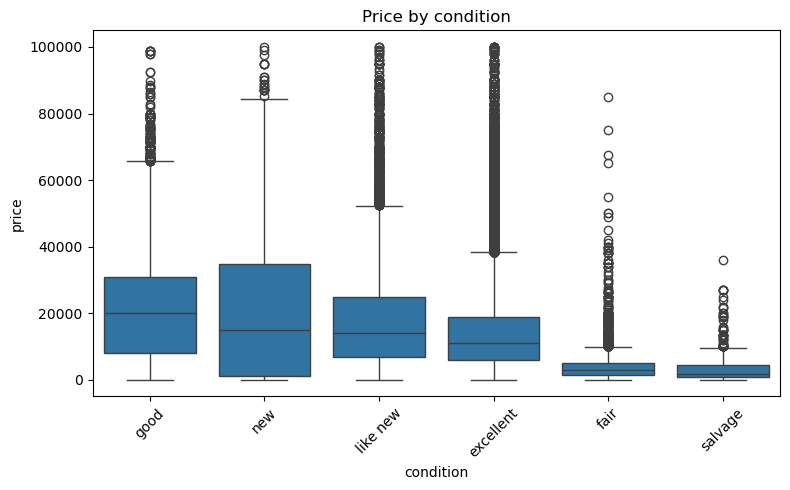

In [17]:
def plot_price_by_category(df, column, max_price=100_000, plot_width=8):
    fig, ax = plt.subplots(figsize=(plot_width, 5))
    plot_data = df[df['price'] < max_price]
    order = plot_data.groupby(column)['price'].median().sort_values(ascending=False).index
    sns.boxplot(data=plot_data, x=column, y='price', order=order, ax=ax)
    ax.set_title(f"Price by {column}")
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

plot_price_by_category(raw_data, 'condition')

### Cylinders & Fuel
`cylinders` and `fuel` should both have an effect on sale price.  High cylinder vehicles usually have larger engines and therefore are more expensive.  Also `electric` and `diesel` fuel types would also be more expensive.  Both of these columns will be included using one-hot encoding (and dropping rows with empty values).

Note: after pruning data based on other columns, `12 cylinders` has a very low sample size.  We will combine it with the `other` group.

In [18]:
raw_data['cylinders'].value_counts(dropna=False)

cylinders
NaN             177678
6 cylinders      94169
4 cylinders      77642
8 cylinders      72062
5 cylinders       1712
10 cylinders      1455
other             1298
3 cylinders        655
12 cylinders       209
Name: count, dtype: int64

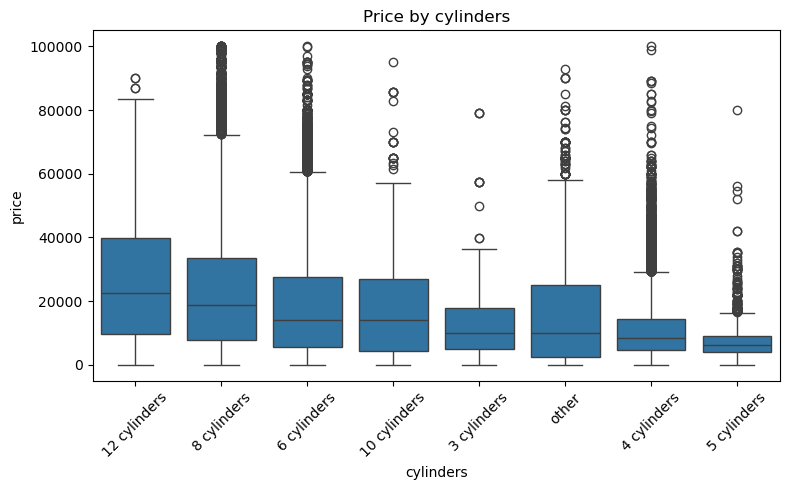

In [19]:
# Plot price metrics grouped by cylinder count
plot_price_by_category(raw_data, 'cylinders')

In [20]:
raw_data['fuel'].value_counts(dropna=False)

fuel
gas         356209
other        30728
diesel       30062
hybrid        5170
NaN           3013
electric      1698
Name: count, dtype: int64

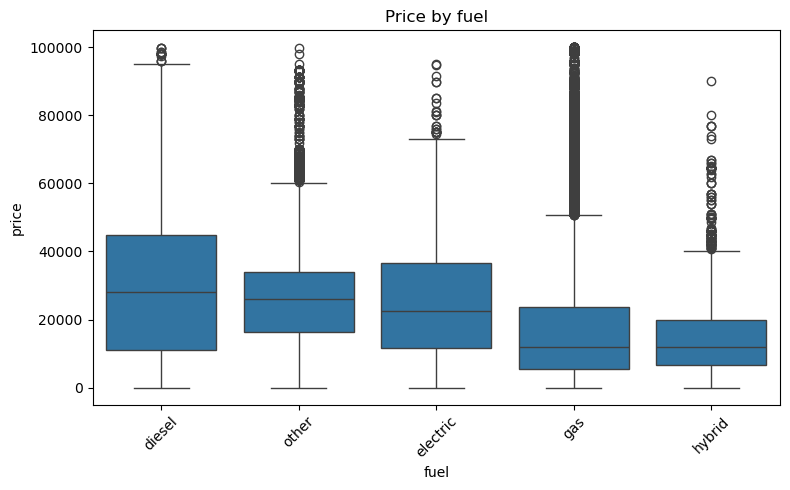

In [21]:
# Plot price metrics grouped by fuel type
plot_price_by_category(raw_data, 'fuel')

### Odometer
The `odometer` represents the number of miles the car has been driven, which is very likely to contribute to the sale price.  It does, however contain outliers with some values reaching close to 1 million.  Rows with outliers, zero, or empty values will be dropped.  

Rows with values less than 1000 are most likely bad data and will be dropped.

Even after dropping outliers, odometer reading still spans across multiple orders of magnitude.  We will replace it with the log of its value in the model.

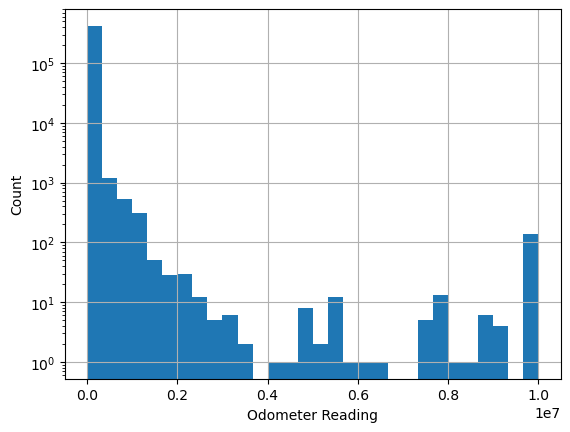

In [22]:
raw_data['odometer'].hist(bins=30, log=True)
plt.xlabel('Odometer Reading')
plt.ylabel('Count')
plt.show()

In [23]:
# Number of rows with odometer reading over 300,000
len(raw_data[raw_data['odometer'] > 300_000])

3032

In [24]:
# Number of rows with odometer reading < 500
len(raw_data[raw_data['odometer'] < 500])

9249

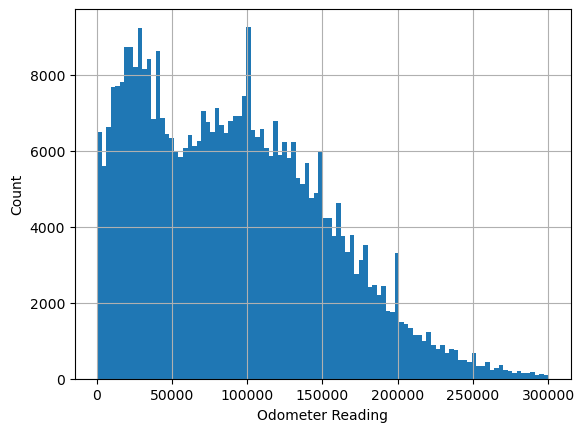

In [25]:
# Histogram of odometer readings over 500 and less than 300,000
raw_data[(raw_data['odometer'] < 300_000) & (raw_data['odometer'] > 500)]['odometer'].hist(bins=100)
plt.xlabel('Odometer Reading')
plt.ylabel('Count')
plt.show()

### Title Status
Vehicles with a `title_status` other than `clean` are special cases that may adversely affect our model, which is trying to assess a normal used car sale, therefore we will drop any row without a `clean` title including rows without a value.  This also means that title status will not be used as a feature as there will only be 1 unique value and it will not contribute to our model.

In [26]:
raw_data['title_status'].value_counts(dropna=False)

title_status
clean         405117
NaN             8242
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: count, dtype: int64

### Transmission
The car sale price doesn't differ significantly between `automatic` and `manual`.  Rows with a `transmission` of `other` are priced higher, but the value isn't intepretable in a general way.  We won't include `transmission` as a feature in the model.

In [27]:
raw_data['transmission'].value_counts(dropna=False)

transmission
automatic    336524
other         62682
manual        25118
NaN            2556
Name: count, dtype: int64

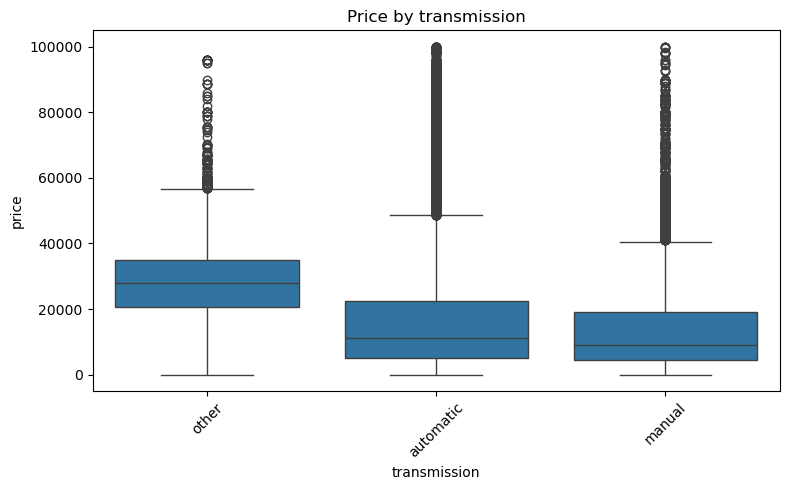

In [28]:
# Plot price metrics grouped by transmission type
plot_price_by_category(raw_data, 'transmission')

### Drive
`drive` is well-formated and has a good distribution among values.  Rows with an empty value should be dropped.

In [29]:
raw_data['drive'].value_counts(dropna=False)

drive
4wd    131904
NaN    130567
fwd    105517
rwd     58892
Name: count, dtype: int64

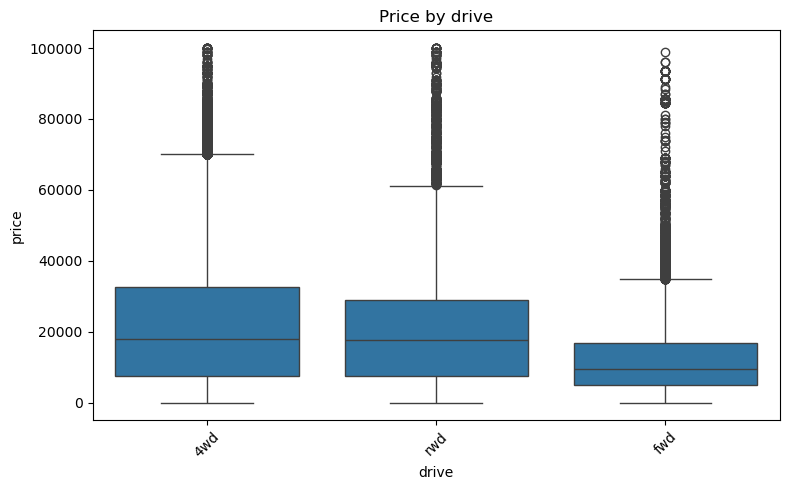

In [30]:
# Plot price metrics grouped by drive type
plot_price_by_category(raw_data, 'drive')

### Size
While `size` does seem to contribute to `price`, namely that `full-size` cars are priced higher, the column contains too many empty values to be useful.  It won't be used as a feature.

In [31]:
raw_data['size'].value_counts(dropna=False)

size
NaN            306361
full-size       63465
mid-size        34476
compact         19384
sub-compact      3194
Name: count, dtype: int64

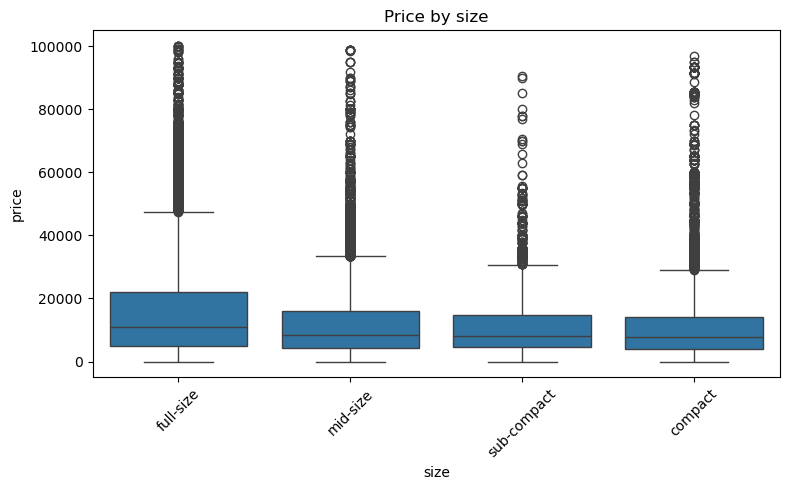

In [32]:
# Plot price metrics grouped by size
plot_price_by_category(raw_data, 'size')

### Type
`type` is likely to have a significant impact on the sale price as, for example, coupes and hatchbacks are likely less expensive than trucks and SUVs.  It is a good candidate for one-hot encoding.  Rows with an empty value and `other` should be dropped.  The values of `truck` and `pickup` might mean the same thing, but without a data dictionary it's difficult to make an assessment on whether they should be combined.  We will leave them separated. 

In [33]:
raw_data['type'].value_counts(dropna=False)

type
NaN            92858
sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
mini-van        4825
offroad          609
bus              517
Name: count, dtype: int64

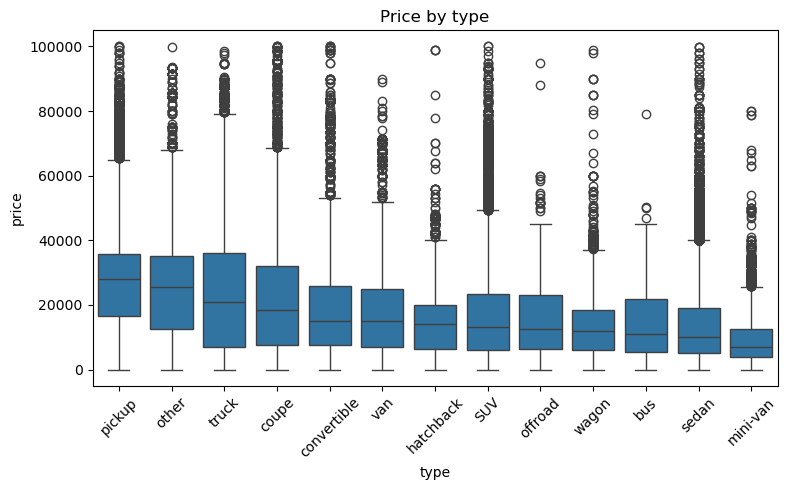

In [34]:
# Plot price metrics grouped by type
plot_price_by_category(raw_data, 'type')

### Paint Color
`paint_color` could have an impact on sale price, with rarer colors like `purple` and `green` being less expensive than common colors like `white` and `black`.  Buyers usually prefer "safe" color to "wild" colors.  We will include the frequency count of the `paint_color` as a feature.

In [35]:
raw_data['paint_color'].value_counts(dropna=False)

paint_color
NaN       130203
white      79285
black      62861
silver     42970
blue       31223
red        30473
grey       24416
green       7343
custom      6700
brown       6593
yellow      2142
orange      1984
purple       687
Name: count, dtype: int64

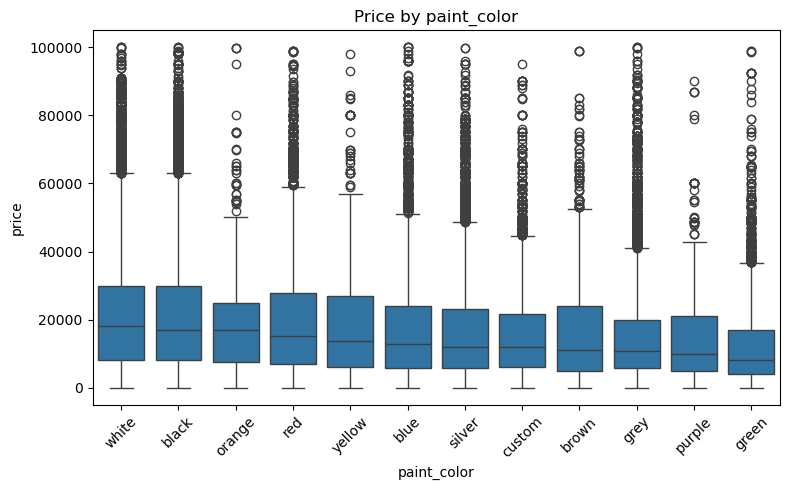

In [36]:
# Plot price metrics grouped by paint color
plot_price_by_category(raw_data, 'paint_color')

### State
`state` of sale could potentially be useful in interesting ways.  For instance, cost of living and stock availability differ between states and therefore probably impact sale prices.  However, our customer is a used car dealership that can (presumably) only sell cars in the state they are located in.  Using `state` as a feature may result in a more accurate model, but it won't help us in advising our customer on what cars to sell.  We won't use `state` as a feature.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [61]:
# Drop rows without a 'clean' title_status.
data = raw_data[raw_data['title_status'] == 'clean']

# Drop unused columns
data = data.drop(columns=['size', 'transmission', 'title_status', 'model', 'region', 'VIN', 'id', 'state'])

# Drop rows with NaN values
data = data.dropna()

# Drop rows with an invalid price below 2000.
# Drop rows with Harley-Davidson as the manufacturer.  They do not make cars.
# Drop rows with incorrect odometer readings below 1000
# Drop rows with a condition of 'new' or 'salvage'
data = data[
  (data['price'] > 2000) &
  (data['manufacturer'] != 'harley-davidson') &
  (data['odometer'] > 1000) &
  (data['condition'] != 'new') &
  (data['condition'] != 'salvage')
]

# Drop duplicate rows
data = data.drop_duplicates()

# Drop rows with outliers in price, year, or odometer.  Use the IQR * 1.5 method
def mark_outliers(column):
    q1, q3 = column.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    return (column < lower_limit) | (column > upper_limit)

outliers = data[['price', 'year', 'odometer']].apply(mark_outliers).any(axis=1)
data = data[~outliers]

In [38]:
# Combine manufacturers with very low sample counts into `other`
manufacturer_counts = data['manufacturer'].value_counts()
rare_manufacturers = manufacturer_counts[manufacturer_counts < 100]
data['manufacturer'] = data['manufacturer'].where(
    data['manufacturer'].isin(manufacturer_counts[manufacturer_counts >= 200].index), 'other'
)
print(f"Combined {len(rare_manufacturers)} manufacturers into 'other':")
print(rare_manufacturers.to_string())

Combined 4 manufacturers into 'other':
manufacturer
alfa-romeo      12
tesla            7
land rover       6
aston-martin     1


In [39]:
# Combine '12 cylinders' into 'other' due to low count
print(f"Combined {data['cylinders'].value_counts()['12 cylinders']} rows of '12 cylinder' into 'other'")
data['cylinders'] = data['cylinders'].replace('12 cylinders', 'other')

Combined 31 rows of '12 cylinder' into 'other'


In [40]:
data.info()

<class 'pandas.DataFrame'>
Index: 58730 entries, 31 to 426833
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         58730 non-null  int64  
 1   year          58730 non-null  float64
 2   manufacturer  58730 non-null  str    
 3   condition     58730 non-null  str    
 4   cylinders     58730 non-null  str    
 5   fuel          58730 non-null  str    
 6   odometer      58730 non-null  float64
 7   drive         58730 non-null  str    
 8   type          58730 non-null  str    
 9   paint_color   58730 non-null  str    
dtypes: float64(2), int64(1), str(7)
memory usage: 7.2 MB


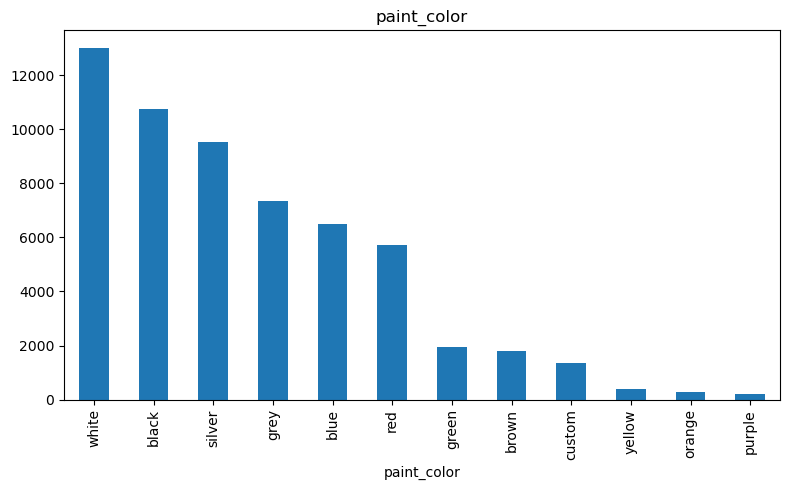

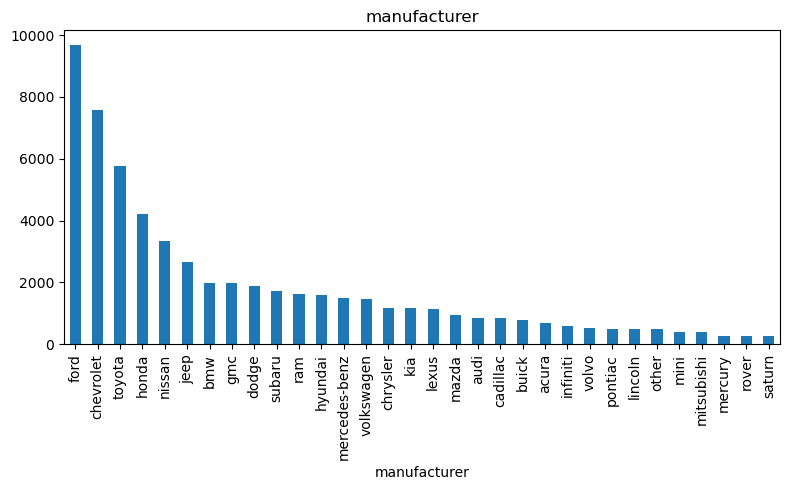

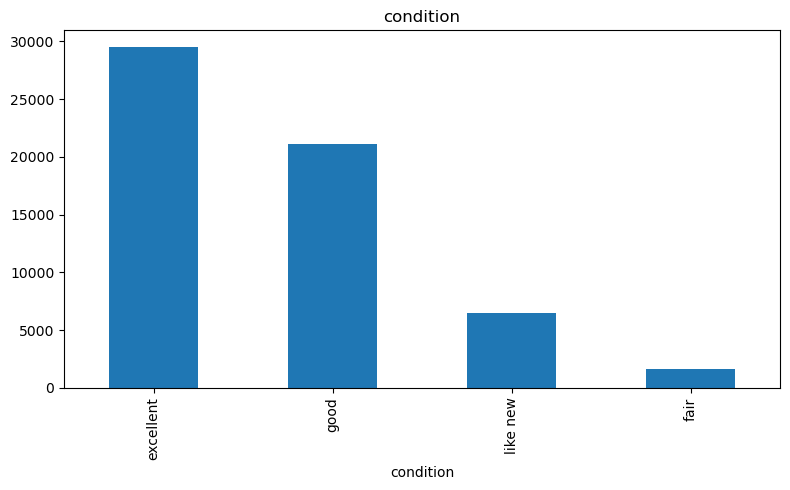

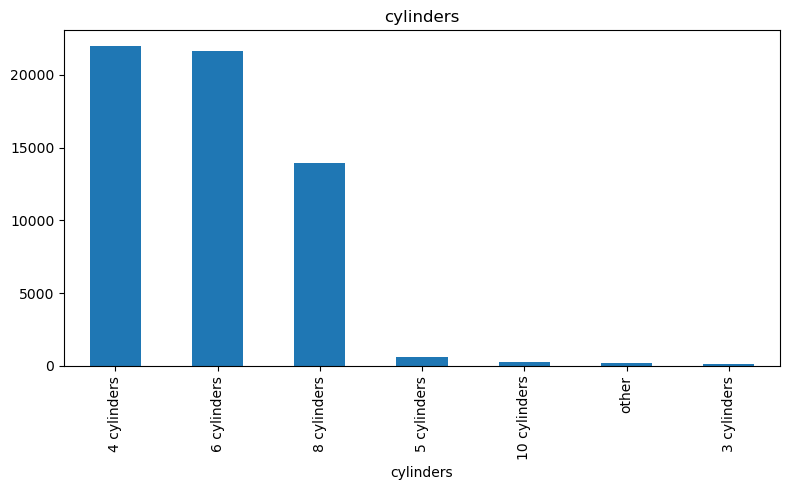

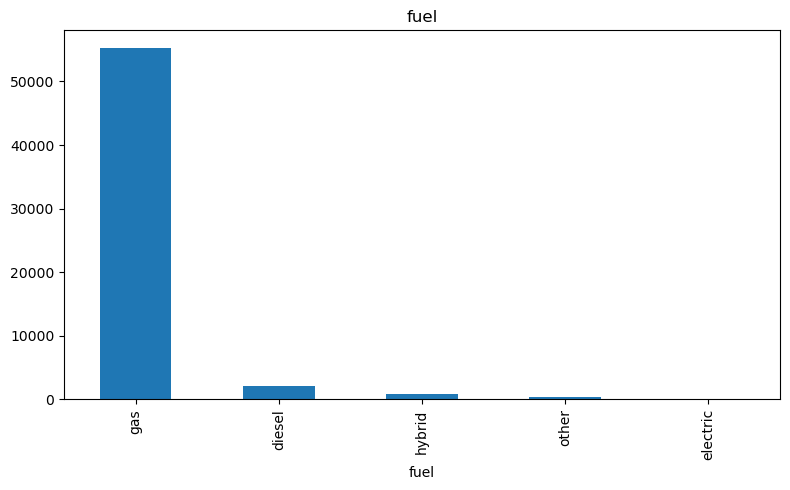

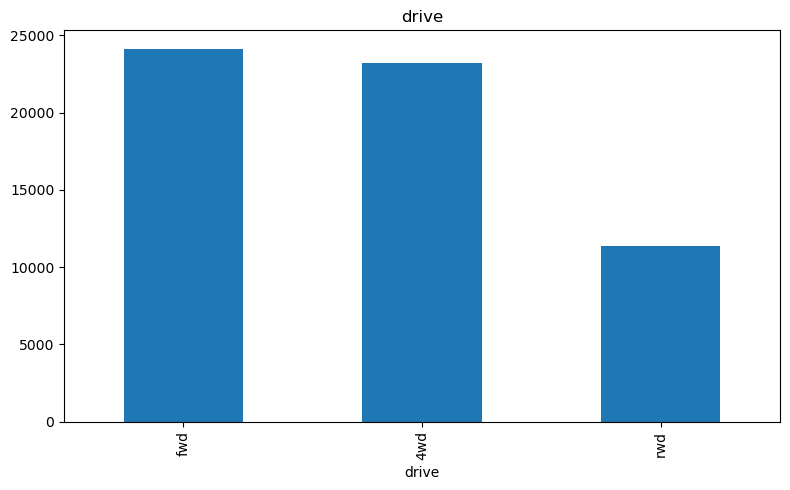

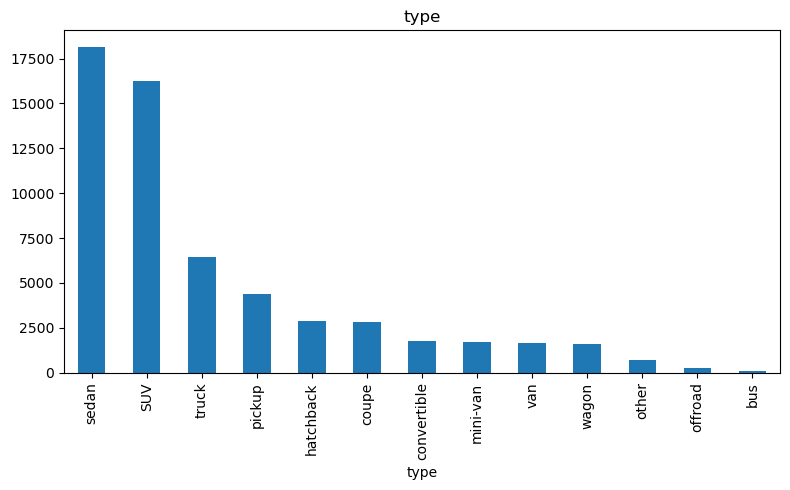

In [41]:
def plot_category_counts(df, column, width=8):
    df[column].value_counts().plot(kind='bar', title=column, figsize=(width, 5))
    plt.tight_layout()
    plt.show()

plot_category_counts(data, 'paint_color')
plot_category_counts(data, 'manufacturer')
plot_category_counts(data, 'condition')
plot_category_counts(data, 'cylinders')
plot_category_counts(data, 'fuel')
plot_category_counts(data, 'drive')
plot_category_counts(data, 'type')

In [42]:
# because price and odometer span multiple orders of magnitude, we'll replace them with the log of their values
data['price'] = np.log(data['price'])
data['odometer'] = np.log(data['odometer'])

In [43]:
# Replace year with age, which is easier to interpret
data['age'] = 2026 - data['year']
data = data.drop(columns=['year'])

In [44]:
# Replace the condition with an ordinal column.
condition_map = {
    'good': 4,
    'like new': 3,
    'excellent': 2,
    'fair': 1
}
data['condition'] = data['condition'].map(condition_map)

In [45]:
# Replace paint_color with frequency counts
paint_color_counts = data['paint_color'].value_counts()
data['paint_color'] = data['paint_color'].map(paint_color_counts)

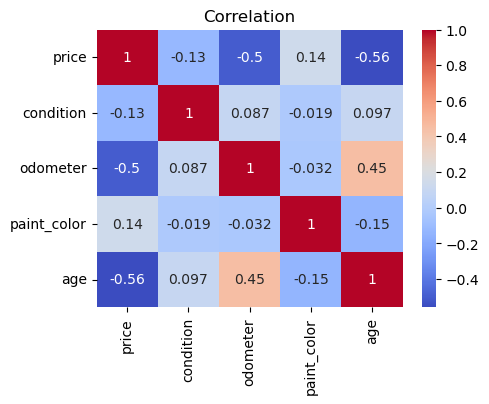

In [46]:
# Correlation matrix of numerical features
df_numeric = data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(5, 4))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.title("Correlation")
plt.show()

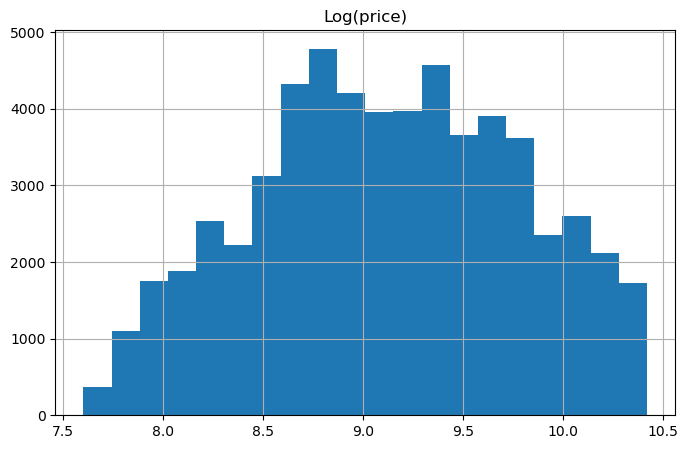

In [47]:
# Histogram of log(price)
data['price'].hist(bins=20, figsize=(8, 5))
plt.title("Log(price)")
plt.show()

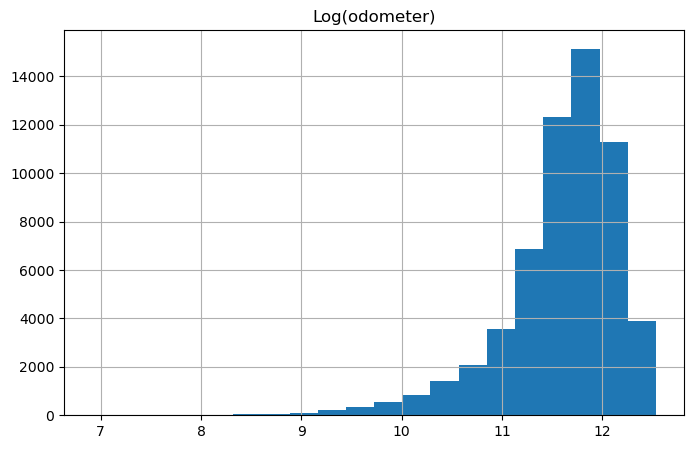

In [48]:
# Histogram of log(odometer)
data['odometer'].hist(bins=20, figsize=(8, 5))
plt.title("Log(odometer)")
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [49]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from datetime import datetime
set_config(display="diagram")

# Separate feature columns and target column
X = data.drop('price', axis=1)
y = data['price'] 

numerical_features = ['age', 'condition', 'odometer', 'paint_color']
categorical_features = ['manufacturer', 'drive', 'type', 'cylinders', 'fuel']

# Split data into train/test sets in a 80/20 ratio.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Only scale and use polynomial expansion with numerical features
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('polyfeatures', PolynomialFeatures())
])

# Create column preprocessor for scaling and encoding columns.  use drop=None for OneHotEncoder because we have many categories
preprocessor = ColumnTransformer(
    transformers = [
        ('numerical', numerical_pipeline, numerical_features),
        ('categorical',
         OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore'),
         categorical_features
        )
    ]
)

# Create the pipeline using Ridge
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())          
])

# Hyperparameters to search
ridge_pipeline_params = {
    'preprocessor__numerical__polyfeatures__degree': [1, 2],
    'ridge__alpha': [0.1, 1.0, 10.0]
}

# Use GridSearchCV to select the best hyperparameters.  It uses cross-validation internally, so we don't need a validation set.
ridge_grid_search = GridSearchCV(
    ridge_pipeline, 
    ridge_pipeline_params, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)
start_time = datetime.now()
ridge_grid_search.fit(X_train, y_train)
elapsed_time = datetime.now() - start_time
print(f"Training completed in {elapsed_time}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training completed in 0:00:03.889330


In [50]:
print(f"Ridge Selected Hyperparameters: {ridge_grid_search.best_params_}")
y_predict_log = ridge_grid_search.predict(X_test)
y_test_dollars = np.exp(y_test)
y_predict_dollars = np.exp(y_predict_log)
rmse = np.sqrt(mean_squared_error(y_test_dollars, y_predict_dollars))
mae = mean_absolute_error(y_test_dollars, y_predict_dollars)
print(f"Ridge Root Mean Squared Error: ${rmse:,.2f}")
print(f"Ridge Mean Absolute Error: ${mae:,.2f}")

Ridge Selected Hyperparameters: {'preprocessor__numerical__polyfeatures__degree': 2, 'ridge__alpha': 0.1}
Ridge Root Mean Squared Error: $3,883.42
Ridge Mean Absolute Error: $2,587.71


In [51]:
# Create the pipeline using Lasso
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso())          
])

# Hyperparameters to search
lasso_pipeline_params = {
    'preprocessor__numerical__polyfeatures__degree': [1, 2],
    'lasso__alpha': [0.001, 0.01, 0.1]
}

# Use GridSearchCV to select the best hyperparameters.  It uses cross-validation internally, so we don't need a validation set.
lasso_grid_search = GridSearchCV(
    lasso_pipeline, 
    lasso_pipeline_params, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)
start_time = datetime.now()
lasso_grid_search.fit(X_train, y_train)
elapsed_time = datetime.now() - start_time
print(f"Training completed in {elapsed_time}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training completed in 0:00:01.493146


In [52]:
print(f"Lasso Selected Hyperparameters: {lasso_grid_search.best_params_}")
y_predict_log = lasso_grid_search.predict(X_test)
y_test_dollars = np.exp(y_test)
y_predict_dollars = np.exp(y_predict_log)
rmse = np.sqrt(mean_squared_error(y_test_dollars, y_predict_dollars))
mae = mean_absolute_error(y_test_dollars, y_predict_dollars)
print(f"Lasso Root Mean Squared Error: ${rmse:,.2f}")
print(f"Lasso Mean Absolute Error: ${mae:,.2f}")

Lasso Selected Hyperparameters: {'lasso__alpha': 0.001, 'preprocessor__numerical__polyfeatures__degree': 2}
Lasso Root Mean Squared Error: $3,912.90
Lasso Mean Absolute Error: $2,630.32


In [53]:
# Create the pipeline using no regression (baseline)
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('linear', LinearRegression())          
])

start_time = datetime.now()
linear_pipeline.fit(X_train, y_train)
elapsed_time = datetime.now() - start_time
print(f"Training completed in {elapsed_time}") # Approx. 11s

y_predict_log = linear_pipeline.predict(X_test)
y_test_dollars = np.exp(y_test)
y_predict_dollars = np.exp(y_predict_log)
rmse = np.sqrt(mean_squared_error(y_test_dollars, y_predict_dollars))
mae = mean_absolute_error(y_test_dollars, y_predict_dollars)
print(f"Linear Root Mean Squared Error: ${rmse:,.2f}")
print(f"Linear Mean Absolute Error: ${mae:,.2f}")

Training completed in 0:00:00.133340
Linear Root Mean Squared Error: $3,883.43
Linear Mean Absolute Error: $2,587.71


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [55]:
# The Ridge model has the lowest RMSE, so that is what we will use
best_model = ridge_grid_search.best_estimator_
coefficients = best_model.named_steps['ridge'].coef_

# build feature names
preprocessor = best_model.named_steps['preprocessor']
numerical_pipeline = preprocessor.named_transformers_['numerical']
polyfeatures_step = numerical_pipeline.named_steps['polyfeatures']
num_features_names = polyfeatures_step.get_feature_names_out(numerical_features)
cat_feature_names = preprocessor.named_transformers_['categorical'].get_feature_names_out(categorical_features)
all_feature_names = list(num_features_names) + list(cat_feature_names)

# find most important features by coefficient
coef_names = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})
coef_names = coef_names[coef_names['abs_coefficient'] > 0.000000]
coef_names = coef_names.sort_values('abs_coefficient', ascending=False)

print("Most Important Features Overall:")
coef_names.head(20)

Most Important Features Overall:


,feature,coefficient,abs_coefficient
70,fuel_diesel,0.448688,0.448688
1,age,-0.412631,0.412631
30,manufacturer_lexus,0.354644,0.354644
63,cylinders_10 cylinders,0.348912,0.348912
34,manufacturer_mercury,-0.344935,0.344935
64,cylinders_3 cylinders,-0.301759,0.301759
56,type_offroad,0.283436,0.283436
3,odometer,-0.257386,0.257386
44,manufacturer_toyota,0.242684,0.242684
68,cylinders_8 cylinders,0.227974,0.227974


In [56]:
# Find most important features for a high sale price
coef_names = coef_names.sort_values('coefficient', ascending=False)
print("Most Important Features for a High Sale Price:")
coef_names[['feature', 'coefficient']].head(10)

Most Important Features for a High Sale Price:


,feature,coefficient
70,fuel_diesel,0.448688
30,manufacturer_lexus,0.354644
63,cylinders_10 cylinders,0.348912
56,type_offroad,0.283436
44,manufacturer_toyota,0.242684
68,cylinders_8 cylinders,0.227974
15,manufacturer_acura,0.203526
60,type_truck,0.184778
25,manufacturer_honda,0.157628
52,type_convertible,0.152124


In [57]:
# Find most important features for a low sale price
coef_names = coef_names.sort_values('coefficient', ascending=True)
print("Most Important Features for a Low Sale Price:")
coef_names[['feature', 'coefficient']].head(10)

Most Important Features for a Low Sale Price:


,feature,coefficient
1,age,-0.412631
34,manufacturer_mercury,-0.344935
64,cylinders_3 cylinders,-0.301759
3,odometer,-0.257386
54,type_hatchback,-0.218122
59,type_sedan,-0.217262
71,fuel_electric,-0.213639
65,cylinders_4 cylinders,-0.185549
42,manufacturer_saturn,-0.177138
55,type_mini-van,-0.160741


In [58]:
# Calculate baseline price (before features are taken into account)
intercept = best_model.named_steps['ridge'].intercept_
baseline_price = np.exp(intercept)
print(f"Baseline price: ${baseline_price:,.2f}")

Baseline price: $11,980.37


In [59]:
# Calculate how age affects sale price.
std_age = data['age'].std()
age_coef = coef_names[coef_names['feature'] == 'age']['coefficient'].values[0]
loss_per_year = 1 - np.exp(age_coef / std_age)
print(f"Each additional year of age decreases price by {loss_per_year:.1%}")

Each additional year of age decreases price by 7.2%


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

### See README.md for full report
Report image generation below.

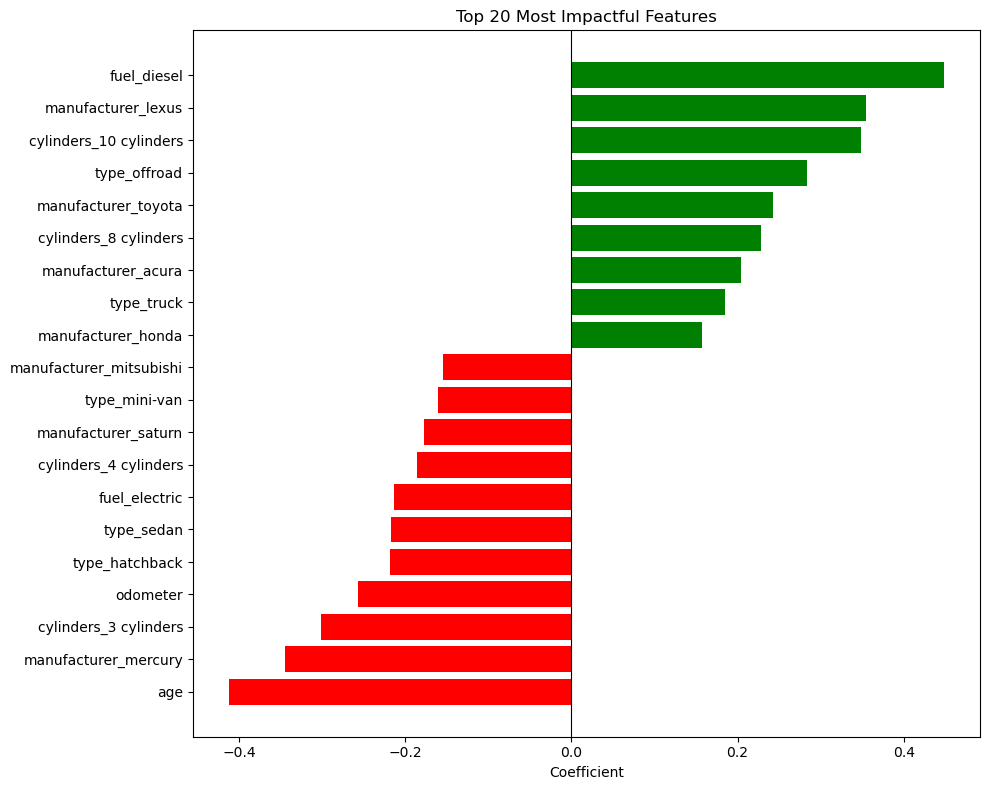

In [64]:
# Plot the most impactful features
plot_data = coef_names.nlargest(20, 'abs_coefficient').sort_values('coefficient')
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['red' if coef < 0 else 'green' for coef in plot_data['coefficient']]
ax.barh(plot_data['feature'], plot_data['coefficient'], color=colors)
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_title('Top 20 Most Impactful Features')
ax.set_xlabel('Coefficient')
plt.tight_layout()
plt.savefig('images/most_impactful_features.png')
plt.show()